Nenwin-project (NEural Networks WIthout Neurons) for
the AI Honors Academy track 2020-2021 at the TU Eindhoven.

Authors: Lulof Pirée

May 2021

Copyright (C) 2021 Lulof Pirée

This program is free software: you can redistribute it and/or modify
it under the terms of the GNU Affero General Public License as published
by the Free Software Foundation, either version 3 of the License, or
(at your option) any later version.

This program is distributed in the hope that it will be useful,
but WITHOUT ANY WARRANTY; without even the implied warranty of
MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the
GNU Affero General Public License for more details.

You should have received a copy of the GNU Affero General Public License
along with this program.  If not, see <https://www.gnu.org/licenses/>.

# Banknote dataset with Nenwin

Dataset source: https://code.datasciencedojo.com/datasciencedojo/datasets/blob/master/Banknote%20Authentication/data_banknote_authentication.txt
See also:
* https://jamesmccaffrey.wordpress.com/2020/08/18/in-the-banknote-authentication-dataset-class-0-is-genuine-authentic/
* https://www.researchgate.net/publication/266673146_Banknote_Authentication

This dataset has:
* 1372 samples, of two classes:
    * class 0 (Genuine): 762 samples 
    * class 1 (Forgery): 610 samples

Features:
* 0: variance (float)
* 1: skewness (float)
* 2: kurtosis (float)
* 3: entropy  (float)


**Goal**: classify which banknotes are real and which ones are forgeries,

based on the four features (that are derived from an image, using the 'Wavelet Transform").

In [1]:
import torch
import torch.nn
import numpy as np
import matplotlib.pyplot as plt

from nenwin.constants import BANKNOTE_CHECKPOINT_DIR
from nenwin.model import NenwinModel
from nenwin.backprop.filename_gen import FilenameGenerator
from nenwin.backprop.trainer import NenwinTrainer
from nenwin.backprop.training_stats import TrainingStats
from nenwin.banknote_dataset.load_dataset import load_banknote_dataset, BanknoteDataset
from nenwin.plot_model import plot_model
from nenwin.banknote_dataset.architectures import ARCHITECTURES, gen_architecture
from nenwin.banknote_dataset.create_trainer import create_trainer

## Architecture generation

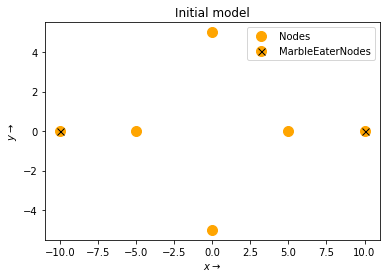

In [2]:
CURRENT_ARCH = ARCHITECTURES.A
MODEL, INPUT_PLACER, EATERS = gen_architecture(CURRENT_ARCH)
fig, ax = plot_model(MODEL)
ax.set_title("Initial model");

## Training setup

In [3]:
LOSS_POS_WEIGHT = 1
LOSS_VEL_WEIGHT = 1
DATASET = load_banknote_dataset()
BATCH_SIZE = 2
TRAINER, FILENAME_GEN = create_trainer(MODEL, 
                         INPUT_PLACER, 
                         EATERS,
                         DATASET,
                         loss_pos_weight= LOSS_POS_WEIGHT,
                         loss_vel_weight = LOSS_VEL_WEIGHT,
                         architecture = CURRENT_ARCH)

## Training loop

In [4]:
num_epochs = 20
step_size = 0.1
num_steps_till_read_output = int(2 / step_size)
do_validate = True
checkpoint_interval = 1

TRAINER.run_training(num_epochs,
                    step_size,
                    num_steps_till_read_output,
                    do_validate,
                    checkpoint_interval,
                    batch_size = BATCH_SIZE)

Epoch 0: saving model...
Model saved as /home/nifrec/Vault/Documents/bachelor_3/honors/nenwin/nenwin/banknote_dataset/checkpoints/BANKNOTE_A_Tue_May_18_21-30-33_2021_checkpoint.txt
Finished epoch 0: loss = 43663.10500526428
Epoch 1: saving model...
Model saved as /home/nifrec/Vault/Documents/bachelor_3/honors/nenwin/nenwin/banknote_dataset/checkpoints/BANKNOTE_A_Tue_May_18_21-30-33_2021_checkpoint.txt
Finished epoch 1: loss = 32628.323788166046
Epoch 2: saving model...
Model saved as /home/nifrec/Vault/Documents/bachelor_3/honors/nenwin/nenwin/banknote_dataset/checkpoints/BANKNOTE_A_Tue_May_18_21-30-33_2021_checkpoint.txt
Finished epoch 2: loss = 27233.958250313997
Epoch 3: saving model...
Model saved as /home/nifrec/Vault/Documents/bachelor_3/honors/nenwin/nenwin/banknote_dataset/checkpoints/BANKNOTE_A_Tue_May_18_21-30-33_2021_checkpoint.txt
Finished epoch 3: loss = 23560.679887346923
Epoch 4: saving model...
Model saved as /home/nifrec/Vault/Documents/bachelor_3/honors/nenwin/nenwin/

In [5]:
stats = TRAINER.training_stats
filename = FILENAME_GEN.gen_filename()
filename = filename.replace(".txt", "_stats.pickle")
import pickle
with open(filename, "wb") as file:
    pickle.dump(stats, file)

Text(0, 0.5, 'Accuracy')

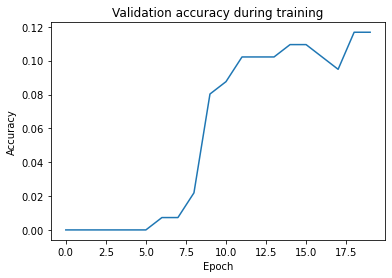

In [6]:
plt.plot(stats.validation_accuracies)
plt.title("Validation accuracy during training")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")

Text(0, 0.5, 'Loss')

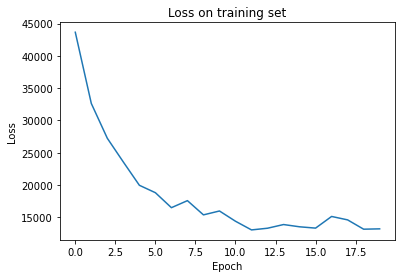

In [14]:
plt.plot(stats.train_losses, label="Training set")
plt.title("Loss on training set")
plt.xlabel("Epoch")
plt.ylabel("Loss")

In [8]:
stats.validation_accuracies

(0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0072992700729927005,
 0.0072992700729927005,
 0.021897810218978103,
 0.08029197080291971,
 0.08759124087591241,
 0.10218978102189781,
 0.10218978102189781,
 0.10218978102189781,
 0.10948905109489052,
 0.10948905109489052,
 0.10218978102189781,
 0.0948905109489051,
 0.11678832116788321,
 0.11678832116788321)

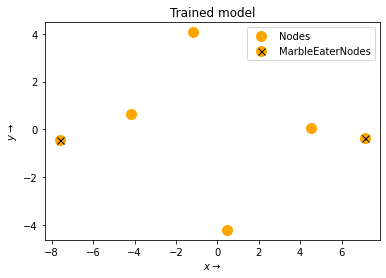

In [9]:
fig, ax = plot_model(MODEL)
ax.set_title("Trained model");

## Loading a saved model
To confirm the saving works. 
No point in training a model if it is lost immediately after!

In [10]:
filename = "/home/nifrec/Vault/Documents/bachelor_3/honors/nenwin/nenwin/banknote_dataset/checkpoints/BANKNOTE_Thu_May_13_16-50-52_2021.txt"
import torch.tensor as tensor
from nenwin.attraction_functions.attraction_functions import ThresholdGravity
with open(filename, "r") as file:
    model = eval(file.readline())

NameError: name 'MarbleEaterNode' is not defined

In [7]:
plot_model(model)

NameError: name 'model' is not defined